# 3D analysis

This tutorial shows how to run a 3D map-based analysis (two spatial and one energy axis).

The example data is three observations of the Galactic center region with CTA.

Warning: this is work in progress, several missing pieces: background, PSF, diffuse and point source models, model serialisation.

We aim to have a first usable version ready and documented here for the Gammapy v0.8 release on May 7, 208.

## Imports and versions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.extern.pathlib import Path
from gammapy.data import DataStore
from gammapy.maps import WcsGeom, MapAxis
from gammapy.cube import MapMaker, PSFKernel

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	path                   : /Users/asinha/Gammapy-dev/gammapy/gammapy 
	version                : 0.8.dev6206 
	githash                : a8591e247f3f5c5e4efb3fac0480d37e0aa49f74 



## Setup

In [4]:
# Define which data to use
data_store = DataStore.from_dir(
    '$GAMMAPY_EXTRA/datasets/cta-1dc/index/gps/'
)
obs_ids = [110380, 111140, 111159]
# obs_ids = [110380]

In [5]:
# Define map geometry (spatial and energy binning)
axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit='TeV', name='energy'
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(20, 15),
    coordsys='GAL', proj='CAR',
    axes=[axis],
)

In [6]:
# We will write some files; let's put them in this path
out_path = Path('analysis_3d')
out_path.mkdir(exist_ok=True)

## Make maps

In [7]:
%%time
maker = MapMaker(geom, 4. * u.deg)

for obs_id in obs_ids:
    print('processing:', obs_id)
    obs = data_store.obs(obs_id)
    maker.process_obs(obs)

processing: 110380


/Users/asinha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


processing: 111140
processing: 111159
CPU times: user 8.69 s, sys: 2.1 s, total: 10.8 s
Wall time: 10.7 s


(<matplotlib.figure.Figure at 0x1823093d68>,
 None)

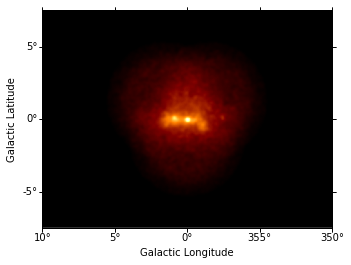

In [8]:
count_map_2d = maker.count_map.sum_over_axes()
count_map_2d.smooth(radius=0.2*u.deg).plot()

In [9]:
maker.count_map.write(str(out_path / 'counts.fits'),overwrite=True)
maker.background_map.write(str(out_path / 'background.fits'),overwrite=True)
maker.exposure_map.write(str(out_path / 'exposure.fits'),overwrite=True)

## Compute PSF kernel
 For the moment we rely on the ObservationList.make_mean_psf() method.

In [10]:
obs_list = data_store.obs_list(obs_ids)

table_psf = obs_list.make_mean_psf(SkyCoord(0.,0.,unit='deg',frame='galactic'))

psf_kernel = PSFKernel.from_table_psf(table_psf, maker.exposure_map.geom, max_radius=1*u.deg)

# Get the energy dispersion

In [11]:
energy = geom.get_axis_by_name('energy')
ene = energy.edges * energy.unit
edisp = obs_list.make_mean_edisp(position=SkyCoord(0.,0.,unit='deg',frame='galactic'), e_true=ene, e_reco=ene)

## Model fit

TODO: add model fit or other kind of analysis here.
For now, see the `simulate_3d` notebook.